In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sn
%matplotlib inline

In [2]:
Retail_df = pd.read_excel("OnlineClean.xlsx")
Retail_df.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
Retail_df.dtypes

Unnamed: 0              int64
InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

把发票日期转为日期时间格式，并计算唯一的属性数

In [4]:
#Convert the date in YYYY-mm-dd HH:MM format and store that date in 'Date' column
Retail_df['Date']=pd.to_datetime(Retail_df['InvoiceDate'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
# Count the unique no of attributes in Retail data
def unique_counts(Retail_df):
   for i in Retail_df.columns:
       count = Retail_df[i].nunique()
       print(i, ": ", count)
unique_counts(Retail_df)

Unnamed: 0 :  397884
InvoiceNo :  18532
StockCode :  3665
Description :  3877
Quantity :  301
InvoiceDate :  17282
UnitPrice :  440
CustomerID :  4338
Country :  37
Date :  17282


总价=数量*单件

In [6]:
Retail_df['Total_Price'] = Retail_df['Quantity'] * Retail_df['UnitPrice']
Retail_df.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total_Price
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01 08:26:00,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01 08:26:00,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34


剔除异常值

In [7]:
# 剔除空数据(NaN)
Online_retail_df = Retail_df[np.isfinite(Retail_df['CustomerID'])]
# 剔除数量小于等于0的数据
final_retail = Online_retail_df[Online_retail_df['Quantity'] > 0]

计算RFM

In [8]:
import datetime as dt
NOW = dt.datetime(2011,12,10)
rfmTable = final_retail.groupby('CustomerID').agg({'Date': lambda x: (NOW - x.max()).days, 
                                                   'InvoiceNo': lambda x: len(x),
                                                   'Total_Price': lambda x: x.sum()})
rfmTable['Date'] = rfmTable['Date'].astype(int)
rfmTable.rename(columns={'Date': 'recency', 
                         'InvoiceNo': 'frequency',
                         'Total_Price': 'monetary_value'}, inplace=True)

In [9]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346,325,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40


**聚类**

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfmTable)

X_scaled[0:5]

array([[ 2.32938811, -0.3965777 ,  8.35866818],
       [-0.90058811,  0.39464896,  0.25096626],
       [-0.17059349, -0.26543516, -0.02859601],
       [-0.74058929, -0.08183561, -0.0330118 ],
       [ 2.17938921, -0.32663501, -0.19134727]])

In [12]:
clusters = KMeans(3)  # 3 clusters
clusters.fit(X_scaled)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

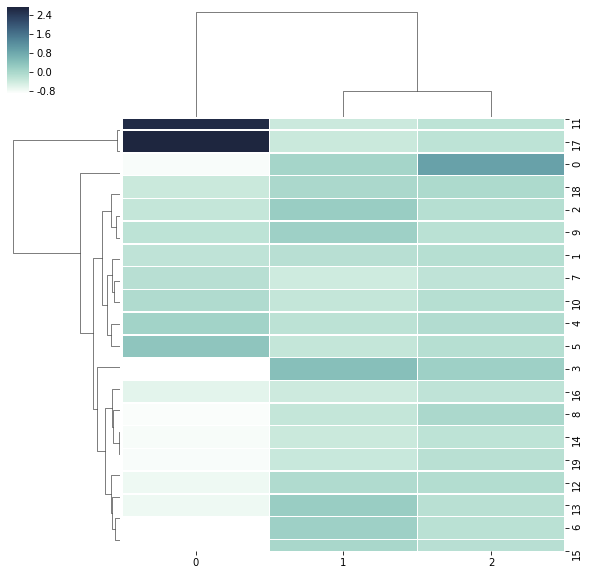

In [13]:
import random
random.seed(2019)
X_sample = np.array(random.sample(X_scaled.tolist(),20))
rfmTable["cluster_new"] = clusters.labels_
rfmTable.drop( 'cluster_new', axis = 1, inplace = True )
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
g = sn.clustermap(X_sample, cmap=cmap, linewidths=.5)

树形图显示有3-6个不同的簇。
随机抽取了20-30个数据点来构建树状图,
考虑使用肘方法来判断类数。

In [14]:
cluster_range = range( 1, 10 )
cluster_errors = []

for num_clusters in cluster_range:
	clusters = KMeans( num_clusters )
	clusters.fit( X_scaled )
	cluster_errors.append( clusters.inertia_ )
    
clusters_df = pd.DataFrame( { "num_clusters": cluster_range, "cluster_errors": cluster_errors } )
clusters_df.head(10)

,num_clusters,cluster_errors
0,1,13014.000000
1,2,8995.083153
2,3,5452.224827
3,4,4006.003405
4,5,2957.725301
5,6,2370.866015
6,7,1922.957141
7,8,1674.083372
8,9,1497.585368


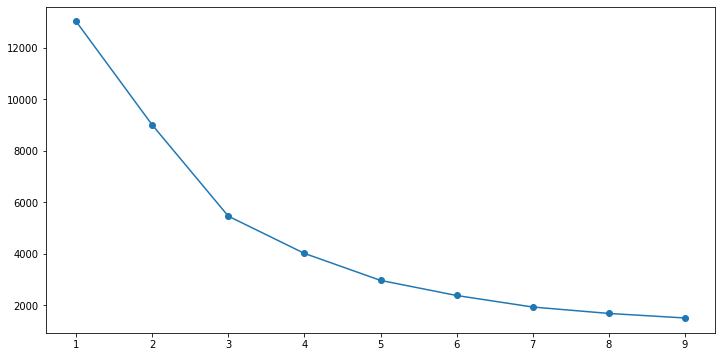

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

从上图看，分3组比较合适。

In [16]:
clusters = KMeans(3)  # 3 clusters
clusters.fit( X_scaled )
rfmTable["cluster_label"] = clusters.labels_
rfmTable.groupby('cluster_label').mean()

,recency,frequency,monetary_value
cluster_label,,,
0,40.906934,103.102003,2029.105908
1,246.813889,27.749074,636.501112
2,4.000000,2565.307692,126118.310000


In [17]:
rfmTable_0 = rfmTable[rfmTable.cluster_label == 0]
rfmTable_0.head(10)

,recency,frequency,monetary_value,cluster_label
CustomerID,,,,
12347,2,182,4310.00,0
12348,75,31,1797.24,0
12349,18,73,1757.55,0
12352,36,85,2506.04,0
12356,22,59,2811.43,0
12357,33,131,6207.67,0
12358,1,19,1168.06,0
12359,57,248,6372.58,0
12360,52,129,2662.06,0


所有高Recency，低frequency，低monetary_value的都分到这组，这些对公司来说，是获得回报最少的客户。

In [18]:
rfmTable_1 = rfmTable[rfmTable.cluster_label == 1]
rfmTable_1.head(10)

,recency,frequency,monetary_value,cluster_label
CustomerID,,,,
12346,325,1,77183.60,1
12350,310,17,334.40,1
12353,204,4,89.00,1
12354,232,58,1079.40,1
12355,214,13,459.40,1
12361,287,10,189.90,1
12365,291,22,641.38,1
12373,311,14,364.60,1
12377,315,77,1628.12,1


In [19]:
rfmTable_2 = rfmTable[rfmTable.cluster_label == 2]
rfmTable_2.head(10)

,recency,frequency,monetary_value,cluster_label
CustomerID,,,,
12415,24,714,124914.53,2
12748,0,4595,33719.73,2
13089,2,1818,58825.83,2
14096,4,5111,65164.79,2
14156,9,1400,117379.63,2
14646,1,2076,280206.02,2
14911,1,5675,143825.06,2
15311,0,2379,60767.90,2
16446,0,3,168472.50,2


低recency，高频次，高monetary，公司最有价值的客户。